In [62]:
'''
In this file, we train a model which we will susequently reason with to explain superposition over ambiguity and different interpretations of ambiguous sentences

THIS IS THE AMBIGUITY FILE OF INTEREST!! 
'''

# import all sorts of stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [63]:
import numpy as np

BATCH_SIZE = 10

SEED = 2

LEARNING_RATE = 3e-2


In [64]:
sentenceWithLabel = []

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
            sentenceWithLabel.append((line[1:].strip(), [t, 1-t]))
    return sentenceWithLabel

import random 



def train_test_split(data, test_size=0.2):

    random.shuffle(data)
    # Split the data into training and testing sets
    split_index = int(len(data) * (1 - test_size))
    train_data = data#[:split_index]
    # test_data = data[split_index:]
    return train_data#, test_data

# note that words labelled with '1', receive the label  |0> = [1,0]

# data = read_data('../datasets/newDataset/animalsVerbs.txt')
data = read_data('dataset.txt')
trainData = train_test_split(data)

print(trainData)

train_labels = []
trainSentences = []
for i in range(len(trainData)):
    sent, lab = trainData[i]
    train_labels.append(lab)
    trainSentences.append(sent)

# test_labels = []
# testSentences = []
# for i in range(len(trainData)):
#     sent, lab = trainData[i]
#     test_labels.append(lab)
#     testSentences.append(sent)

# print(sentences)

# print(testSentences)



[('pasta is starving', [0, 1]), ('men are delicious', [0, 1]), ('women are tasty', [0, 1]), ('pancakes are tasty', [1, 0]), ('pasta is delicious', [1, 0]), ('men are hungry', [1, 0]), ('pasta is hungry', [0, 1]), ('women are hungry', [1, 0]), ('pancakes are starving', [0, 1]), ('pancakes are delicious', [1, 0]), ('men are tasty', [0, 1]), ('women are delicious', [0, 1]), ('women are starving', [1, 0]), ('pasta is tasty', [1, 0]), ('pancakes are hungry', [0, 1]), ('men are starving', [1, 0])]


In [65]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(trainSentences, suppress_exceptions=True)
# raw_test_diagrams = parser.sentences2diagrams(testSentences, suppress_exceptions=True)

KeyboardInterrupt: 

In [ ]:
from lambeq.backend.grammar import Cup, Diagram, Id, Word
from lambeq.backend.drawing import draw

from lambeq import AtomicType

N = AtomicType.NOUN
S = AtomicType.SENTENCE
from lambeq import Rewriter

rewriter = Rewriter()

# diagram = ((Word('we', N) @ Word('will', (N >> S) << (N >> S)) @
#             Word('go', N >> S)) >>
#            Cup(N, N.r) @ Id(S) @ Diagram.cups((N >> S).l, N >> S))

# diagram = raw_train_diagrams[2]

# draw(diagram)
# print('↓ rewriting (auxiliary rule)')
# draw(Rewriter(['auxiliary'])(diagram))
# print('↓ normal form')
# draw(rewriter(diagram).normal_form())

In [ ]:
# first, boys are hungry -> boys hungry 

from lambeq import Rewriter

rewriter = Rewriter()

raw_train_diagrams_new = [Rewriter(['auxiliary'])(diagram).normal_form() for diagram in raw_train_diagrams]
# raw_test_diagrams_new = [Rewriter(['auxiliary'])(diagram).normal_form() for diagram in raw_test_diagrams]



# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams_new]
# test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams_new]

# for diag in train_diagrams:
#     diag.draw()

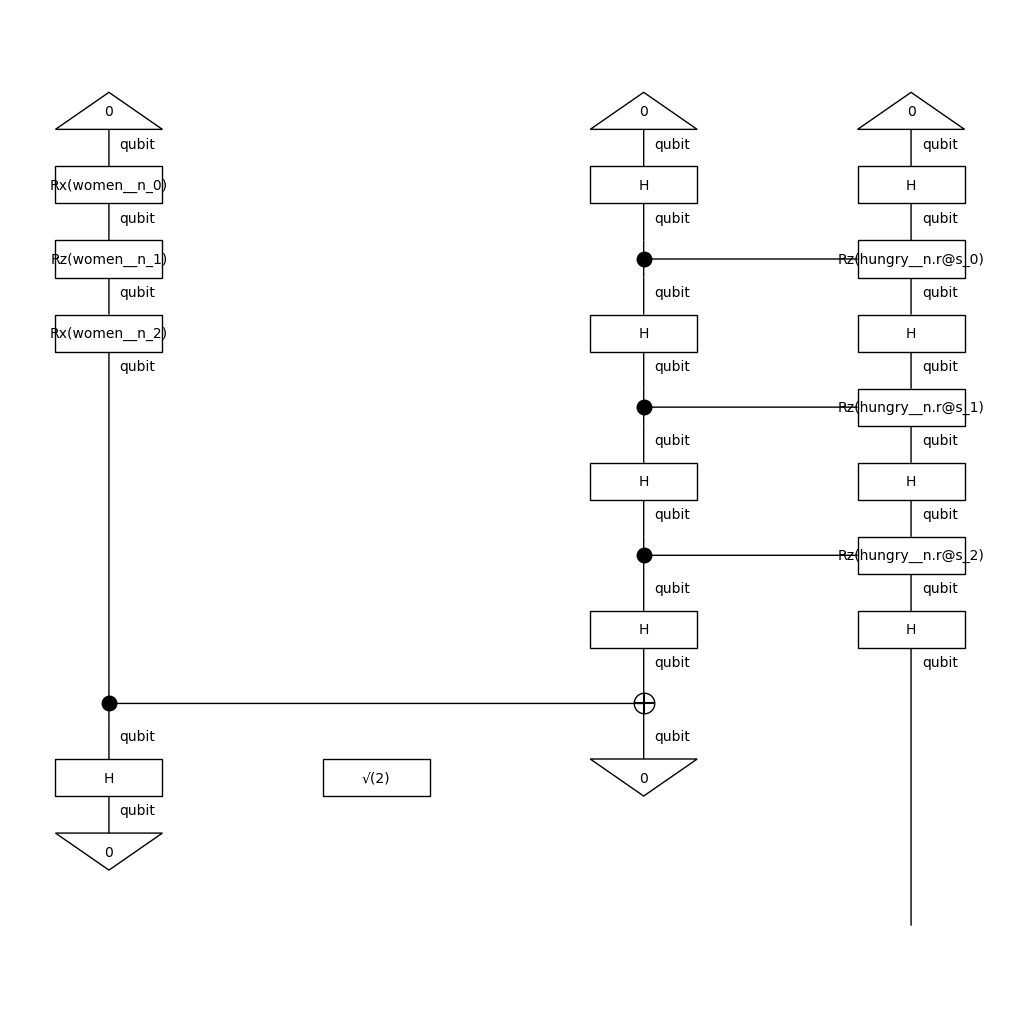

In [ ]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

# choose IQP ansatz with one qubit each and 2 layers I gues 
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=3, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in raw_train_diagrams_new]
# test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize= (10,10))

In [ ]:
from lambeq import Dataset

all_circuits = train_circuits# + test_circuits

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
# test_dataset = Dataset(test_circuits, test_labels)



In [ ]:
'''
Same thing, but for Tket model 
'''

EPOCHS = 600


from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset)#, test_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 2.5987   valid/loss: -----   train/acc: 0.3125   valid/acc: -----
Epoch 2:    train/loss: 0.6512   valid/loss: -----   train/acc: 0.4375   valid/acc: -----
Epoch 3:    train/loss: 1.2741   valid/loss: -----   train/acc: 0.4375   valid/acc: -----
Epoch 4:    train/loss: 0.7287   valid/loss: -----   train/acc: 0.5625   valid/acc: -----
Epoch 5:    train/loss: 1.0558   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 6:    train/loss: 0.9085   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 7:    train/loss: 1.1372   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 8:    train/loss: 0.5507   valid/loss: -----   train/acc: 0.5625   valid/acc: -----
Epoch 9:    train/loss: 1.1772   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 10:   train/loss: 0.8384   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 11:   train/loss: 1.1053   valid/loss: -----   train/acc: 0.5312   valid/acc: -----
Epoch 12: 

KeyError: 'Unknown symbol: women__n_0'

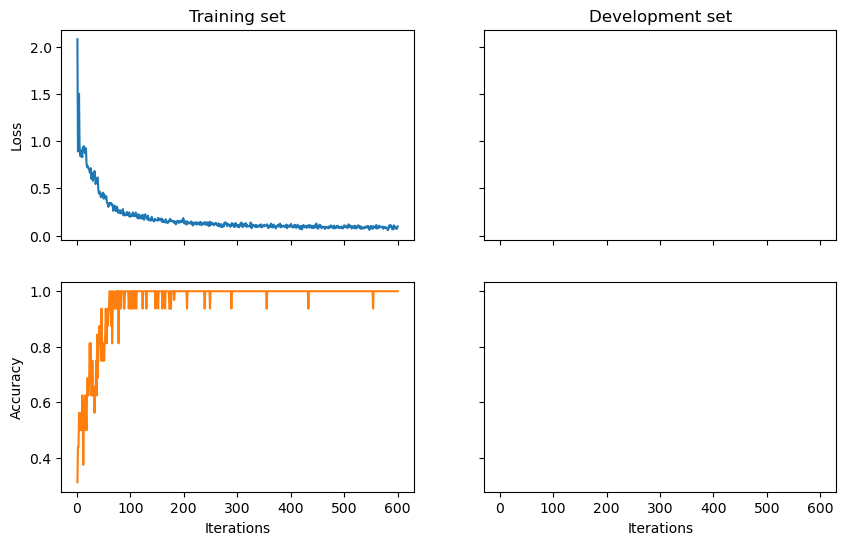

In [74]:
import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
# ax_tr.plot(range_, trainer.val_costs, color=next(colours))
# ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
# pred = model(test_circuits)
# labels = torch.tensor(test_labels)


# print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
# modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(train_circuits), train_labels)
print('Validation accuracy:', val_acc.item())

test_loss = BinaryCrossEntropyLoss()

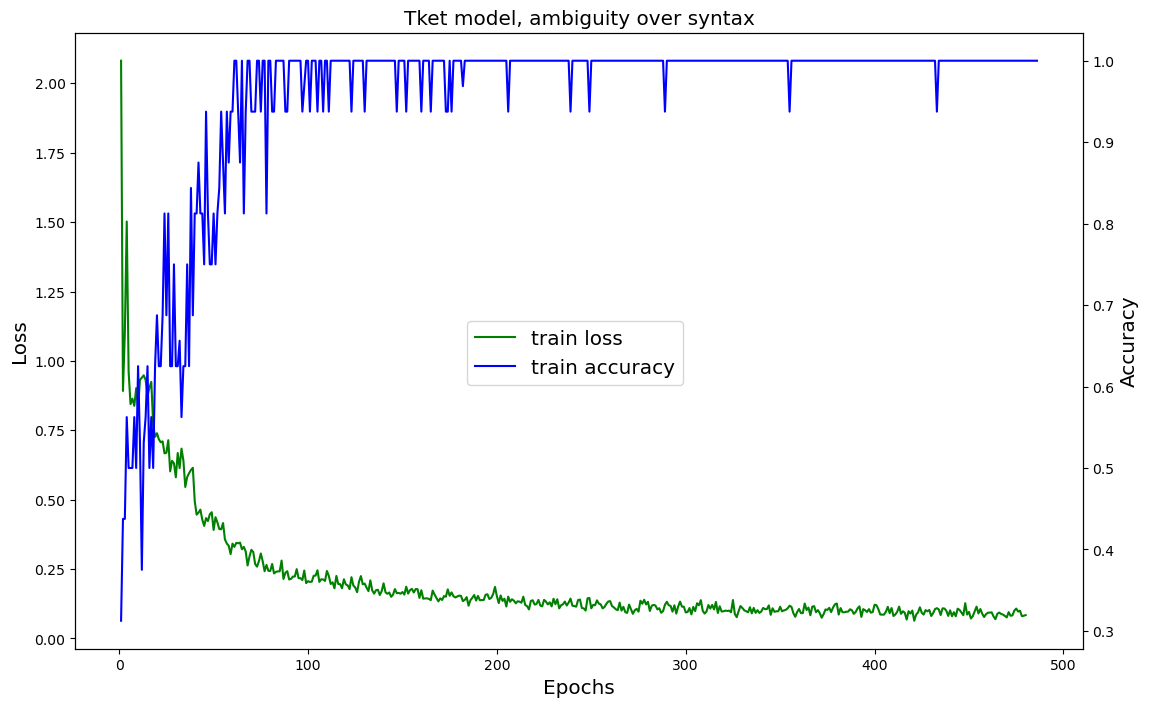

In [89]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

# ax1.plot(range_, trainer.train_epoch_costs, '-k', markersize=4, label='cost')
ax1.plot(range_[:int(len(range_) * 0.833333)], trainer.train_epoch_costs[:int(len(range_) * 0.833333)], '-g', markersize=4, label='train loss')
# ax1.plot(range_, trainer.train_eval_results['acc'], '-b', markersize=4, label='train accuracy')
ax1.set_ylabel(r"Loss", fontsize='x-large')
ax1.set_xlabel(r"Epochs", fontsize='x-large')
# ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.plot(range_[:int(len(range_) * 0.833333)], trainer.train_eval_results['acc'][:int(len(range_) * 0.833333)], '-b', markersize=4, label='train accuracy')
ax2.set_ylabel(r"Accuracy", fontsize='x-large')
# ax2.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
# ax2.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
# ax2.plot(range(len(trainer.train_costs)), trainer.train_costs, '-r', markersize=4, label='test error')
# ax1.legend(loc='center', fontsize='x-large')
# ax2.legend(loc='upper right', fontsize='x-large')

fig.legend(loc='center', fontsize='x-large')

plt.title('Tket model, ambiguity over syntax', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()

In [ ]:
smbls = modelTK.symbols
# And the weights are their respective values 
weights = modelTK.weights

print(smbls)
print(weights)


[delicious__n.r@s_0, delicious__n.r@s_1, delicious__n.r@s_2, hungry__n.r@s_0, hungry__n.r@s_1, hungry__n.r@s_2, men__n_0, men__n_1, men__n_2, pancakes__n_0, pancakes__n_1, pancakes__n_2, pasta__n_0, pasta__n_1, pasta__n_2, starving__n.r@s_0, starving__n.r@s_1, starving__n.r@s_2, tasty__n.r@s_0, tasty__n.r@s_1, tasty__n.r@s_2, women__n_0, women__n_1, women__n_2]
[ 1.64281711 -0.50822201  1.33025242 -0.05855358  0.08580051  1.8020639
  0.0467799   1.12588855  1.12255799  0.93739624  1.32794128  1.51515936
  1.42313475 -0.3657919   0.99223649 -0.18223484 -0.30818894  0.38804873
  1.62742924 -0.43567011 -0.62691215  1.54642364  0.81341098  0.64034106]


In [ ]:
import re 

def extract_word_and_number(strings):
    new_strings = []
    for s in strings:
        match = re.match(r'^([a-zA-Z]+).*?(\d+)$', str(s))
        # print(str(s))
        if match:
            new_strings.append(f"{match.group(1)}{match.group(2)}")
    return new_strings

newSmbls = extract_word_and_number(smbls)
# print(weights)

parameterDict = {}

for i in range(len(newSmbls)):
    parameterDict[newSmbls[i]] = weights[i]

print(parameterDict)


{'delicious0': 1.6428171144690051, 'delicious1': -0.508222010843409, 'delicious2': 1.3302524177988604, 'hungry0': -0.05855357501552647, 'hungry1': 0.08580051439404543, 'hungry2': 1.8020638990454476, 'men0': 0.046779901982235195, 'men1': 1.1258885519558066, 'men2': 1.1225579935436265, 'pancakes0': 0.9373962392634599, 'pancakes1': 1.32794127849774, 'pancakes2': 1.5151593569740984, 'pasta0': 1.4231347470751348, 'pasta1': -0.36579189638108905, 'pasta2': 0.9922364894876947, 'starving0': -0.18223483703112783, 'starving1': -0.30818893954373366, 'starving2': 0.3880487347659513, 'tasty0': 1.6274292402623611, 'tasty1': -0.4356701101841144, 'tasty2': -0.6269121506473381, 'women0': 1.54642363741648, 'women1': 0.8134109750223204, 'women2': 0.640341058347837}


In [ ]:
#  construct the circuit in qiskit 

# catHuntsDog = 'dog hunts cat'
# # testSentence2 = 'cat is fast'

# catHuntsDogDiag = parser.sentence2diagram(catHuntsDog)

# CHDcircuit = ansatz(catHuntsDogDiag)

# CHDcircuit.draw(figsize = (10,10))

In [ ]:
# now, it hides circuit 
# itHides = 'it hides'
# # testSentence2 = 'cat is fast'

# itHidesDiag = parser.sentence2diagram(itHides)

# itHidescircuit = ansatz(itHidesDiag)

# itHidescircuit.draw()

# tketCirc = itHidescircuit.to_tk()


In [ ]:
# itHidesTketCirc = itHidescircuit.to_tk()

# catHuntsDogTket = CHDcircuit.to_tk()

from pytket.extensions.qiskit import tk_to_qiskit

# iHQiskit = tk_to_qiskit(itHidesTketCirc)
# cHDQiskit = tk_to_qiskit(catHuntsDogTket)

# # iHQiskit.draw()
# cHDQiskit.draw()


In [70]:
from qiskit.circuit import ParameterVector, Parameter

def DefaultCircuits(nounOne, adjective):
    ''''''

    qc = QuantumCircuit(3)
    

    thetaSubj1 = Parameter(str(nounOne) + '2')
    thetaSubj2 = Parameter(str(nounOne) + '1')
    thetaSubj3 = Parameter(str(nounOne) + '0')

    thetaAdj1  = Parameter(str(adjective) + '0')
    thetaAdj2  = Parameter(str(adjective) + '1')
    thetaAdj3  = Parameter(str(adjective) + '2')

    qc.rx(thetaSubj1, 0)
    qc.rz(thetaSubj2, 0)
    qc.rx(thetaSubj3, 0)

    # layer one 
    qc.h(1)
    qc.h(2)

    qc.crz(thetaAdj1, 1,2)

    qc.h(1)
    qc.h(2)

    # layer two

    qc.crz(thetaAdj2, 1,2)

    qc.h(1)
    qc.h(2)

    # layer three

    qc.crz(thetaAdj3, 1,2)

    qc.h(1)
    qc.h(2)

    qc.cx(0,1)

    qc.h(0)

    params = qc.parameters
    # set the parameters of the remaining words based on the models weights 
    for i in range(len(params)):
        print(params[i])
        if str(params[i]) in parameterDict:

            # print('DEBUGDEBUGDEBUGDEBUG,  if we put in parameter ', parameterDict[str(params[i])], 'for the label: ', str(params[i]))
            qc = qc.assign_parameters({params[i]: 2*np.pi*(parameterDict[str(params[i])])})
            print(parameterDict[str(params[i])])

    return qc


circuit = DefaultCircuits('women', 'hungry')
circuit2 = DefaultCircuits('men', 'hungry')
circuit3 = DefaultCircuits('women', 'starving')
circuit4 = DefaultCircuits('men', 'starving')
circuit5= DefaultCircuits('pancakes', 'tasty')
circuit6 = DefaultCircuits('pasta', 'tasty')
circuit7= DefaultCircuits('pancakes', 'delicious')
circuit8 = DefaultCircuits('pasta', 'delicious')
print(circuit)

def GetDMFromCircuit(circuit):


    import qiskit.quantum_info as qi 

    # rho = qi.DensityMatrix(circuit)
    rho = qi.Statevector(circuit)
    tempRho = rho.measure([0,1])

    while '1' in tempRho[0]:
        tempRho = rho.measure([0, 1])

    print(tempRho[0])

    rhoNew = tempRho[1]
    rhoFinal = qi.partial_trace(rhoNew, [0,1])

    return rhoFinal

import qiskit.quantum_info as qi 

sigma = qi.DensityMatrix([[0,0] ,[0,1]])

rhoFinal1 = qi.state_fidelity(GetDMFromCircuit(circuit), sigma)
rhoFinal2 = qi.state_fidelity(GetDMFromCircuit(circuit2), sigma)
rhoFinal3 = qi.state_fidelity(GetDMFromCircuit(circuit3), sigma)
rhoFinal4 = qi.state_fidelity(GetDMFromCircuit(circuit4), sigma)
rhoFinal5= qi.state_fidelity(GetDMFromCircuit(circuit5), sigma)
rhoFinal6 = qi.state_fidelity(GetDMFromCircuit(circuit6), sigma)
rhoFinal7= qi.state_fidelity(GetDMFromCircuit(circuit7), sigma)
rhoFinal8 = qi.state_fidelity(GetDMFromCircuit(circuit8), sigma)

result = rhoFinal8 + rhoFinal1 + rhoFinal2 + rhoFinal3 + rhoFinal4 + rhoFinal5 + rhoFinal6 + rhoFinal7
result = result / 8

print('avg fidelity: ', result)


    

hungry0
-0.05855357501552647
hungry1
0.08580051439404543
hungry2
1.8020638990454476
women0
1.54642363741648
women1
0.8134109750223204
women2
0.640341058347837
hungry0
-0.05855357501552647
hungry1
0.08580051439404543
hungry2
1.8020638990454476
men0
0.046779901982235195
men1
1.1258885519558066
men2
1.1225579935436265
starving0
-0.18223483703112783
starving1
-0.30818893954373366
starving2
0.3880487347659513
women0
1.54642363741648
women1
0.8134109750223204
women2
0.640341058347837
men0
0.046779901982235195
men1
1.1258885519558066
men2
1.1225579935436265
starving0
-0.18223483703112783
starving1
-0.30818893954373366
starving2
0.3880487347659513
pancakes0
0.9373962392634599
pancakes1
1.32794127849774
pancakes2
1.5151593569740984
tasty0
1.6274292402623611
tasty1
-0.4356701101841144
tasty2
-0.6269121506473381
pasta0
1.4231347470751348
pasta1
-0.36579189638108905
pasta2
0.9922364894876947
tasty0
1.6274292402623611
tasty1
-0.4356701101841144
tasty2
-0.6269121506473381
delicious0
1.64281711446900

In [86]:
from qiskit.circuit import ParameterVector, Parameter

def CreateCircuit(nounOne, nounTwo, adjective, prob1):
    qc = QuantumCircuit(5)

    thetaSubj1 = Parameter(str(nounOne) + '2')
    thetaSubj2 = Parameter(str(nounOne) + '1')
    thetaSubj3 = Parameter(str(nounOne) + '0')

    thetaObj1 = Parameter(str(nounTwo) + '2')
    thetaObj2 = Parameter(str(nounTwo) + '1')
    thetaObj3 = Parameter(str(nounTwo) + '0')

    thetaAdj1  = Parameter(str(adjective) + '0')
    thetaAdj2  = Parameter(str(adjective) + '1')
    thetaAdj3  = Parameter(str(adjective) + '2')

    qc.rx(thetaSubj1, 1)
    qc.rz(thetaSubj2, 1)
    qc.rx(thetaSubj3, 1)

    qc.rx(thetaObj1, 2)
    qc.rz(thetaObj2, 2)
    qc.rx(thetaObj3, 2)


    # if not prob1 == 0.5:
    # alpha = prob1 / ( (prob1**2 + (1- prob1)**2) )
    # # else: 
    # #     alpha = 0.5

    # # alpha = np.sqrt(prob1)

    # # print('alpha is:', alpha)

    vector = [prob1, 1-prob1]
    initialState = vector / np.linalg.norm(vector)

    # vector = [prob1, 1-prob1]

    # print(initialState)

    # qc.initialize(initialState, 0, normalize=False)



    qc.h(0)
    qc.h(3)
    qc.h(4)
    qc.crz(thetaAdj1, 3, 4)
    qc.h(3)
    qc.h(4)

    # layer two

    qc.crz(thetaAdj2,3, 4)

    qc.h(3)
    qc.h(4)

    # layer three

    qc.crz(thetaAdj3,3, 4)

    qc.h(3)
    qc.h(4)

    qc.ccx(0, 2, 3)
    qc.x(0)
    qc.ccx(0, 1, 3)

    qc.h(1)
    qc.h(2)

    # qc.measure(1,0)
    # qc.measure(2,0)
    # qc.measure(3,0)


    params = qc.parameters
    # set the parameters of the remaining words based on the models weights 
    for i in range(len(params)):
        if str(params[i]) in parameterDict:

            # print('DEBUGDEBUGDEBUGDEBUG,  if we put in parameter ', parameterDict[str(params[i])], 'for the label: ', str(params[i]))
            qc = qc.assign_parameters({params[i]: 2* np.pi*(parameterDict[str(params[i])])})

    return qc

import qiskit.quantum_info as qi 
adjList = ['hungry', 'starving', 'delicious', 'tasty']
subjectList = ['men', 'women', 'pancakes', 'pasta']

def GetEntropyAndFidelity(word1, word2, word3):
    circuit = CreateCircuit(word1, word2, word3, 0)

    print(circuit)

    rho = qi.DensityMatrix(circuit)
    tempRho = rho.measure([1,2,3])

    while '1' in tempRho[0]:
        tempRho = rho.measure([1,2,3])

    rho = tempRho[1]
    rho = qi.partial_trace(rho, [0,1,2,3])

    sigma = qi.DensityMatrix([[1,0] ,[0,0]])

    return qi.state_fidelity(sigma, rho), qi.entropy(rho)

listOfEntropy = []
listOfFidelity = []

listOfEntropy.append(GetEntropyAndFidelity('men', 'pancakes', 'hungry')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pancakes', 'hungry')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pancakes', 'starving')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pancakes', 'starving')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pasta', 'hungry')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pasta', 'hungry')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pasta', 'starving')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pasta', 'starving')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pancakes', 'delicious')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pancakes', 'delicious')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pancakes', 'tasty')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pancakes', 'tasty')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pasta', 'delicious')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pasta', 'delicious')[0])

listOfEntropy.append(GetEntropyAndFidelity('men', 'pasta', 'tasty')[1])
listOfFidelity.append(GetEntropyAndFidelity('men', 'pasta', 'tasty')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pancakes', 'hungry')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pancakes', 'hungry')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pancakes', 'starving')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pancakes', 'starving')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pasta', 'hungry')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pasta', 'hungry')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pasta', 'starving')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pasta', 'starving')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pancakes', 'delicious')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pancakes', 'delicious')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pancakes', 'tasty')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pancakes', 'tasty')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pasta', 'delicious')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pasta', 'delicious')[0])

listOfEntropy.append(GetEntropyAndFidelity('women', 'pasta', 'tasty')[1])
listOfFidelity.append(GetEntropyAndFidelity('women', 'pasta', 'tasty')[0])


print('average entropy: ', sum(listOfEntropy)/len(listOfEntropy))
print('average fidelity: ', sum(listOfFidelity) / len(listOfFidelity))


# print(result)
# result.draw('latex')


         ┌───┐                                                      »
q_0: ────┤ H ├──────────────────────────────────────────────────────»
     ┌───┴───┴────┐ ┌────────────┐┌─────────────┐                   »
q_1: ┤ Rx(7.0532) ├─┤ Rz(7.0742) ├┤ Rx(0.29393) ├───────────────────»
     └┬──────────┬┘ ├────────────┤└┬────────────┤                   »
q_2: ─┤ Rx(9.52) ├──┤ Rz(8.3437) ├─┤ Rx(5.8898) ├───────────────────»
      └──┬───┬───┘  └────────────┘ └───┬───┬────┘              ┌───┐»
q_3: ────┤ H ├────────────■────────────┤ H ├───────────■───────┤ H ├»
         ├───┤     ┌──────┴──────┐     ├───┤     ┌─────┴──────┐├───┤»
q_4: ────┤ H ├─────┤ Rz(-0.3679) ├─────┤ H ├─────┤ Rz(0.5391) ├┤ H ├»
         └───┘     └─────────────┘     └───┘     └────────────┘└───┘»
«                             ┌───┐          
«q_0: ─────────────────────■──┤ X ├──■───────
«                          │  └───┘  │  ┌───┐
«q_1: ─────────────────────┼─────────■──┤ H ├
«                          │  ┌───┐  │  └───┘


In [ ]:
print(rhoFinal)

test = rho.evolve(rhoFinal)
print(np.trace(test))
test = test / np.trace(test)
test.draw('latex')

DensityMatrix([[ 0.95013295+0.j        , -0.11185892-0.18672951j],
               [-0.11185892+0.18672951j,  0.04986705+0.j        ]],
              dims=(2,))
(0.787508252846336-2.7755575615628914e-17j)


<IPython.core.display.Latex object>

In [ ]:




# test 
import qiskit.quantum_info as qi 
from qiskit import QuantumCircuit
qc = QuantumCircuit(3)
# qc.x(0)
qc.h(2)
qc.cx(2,1)
qc.x(2)
qc.cx(2,0)
print(qc)

test = qi.Operator(qc)
print()
print(test.data)

test.draw('latex')
# print(qc)

# print(test)

# dm = qi.DensityMatrix(qc)
# print(dm.data)
# dm = qi.partial_trace(dm, [0])

# print(dm.data)

# dm.draw('latex')

# dm.measure([0,1])

# for i in range(100): 
#     print(dm.measure([0,1])[0])



                    ┌───┐
q_0: ───────────────┤ X ├
          ┌───┐     └─┬─┘
q_1: ─────┤ X ├───────┼──
     ┌───┐└─┬─┘┌───┐  │  
q_2: ┤ H ├──■──┤ X ├──■──
     └───┘     └───┘     

[[ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.        +0.j
   0.        +0.j  0.        +0.j -0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.70710678+0.j
   0.        +0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j
  -0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.        +0.j
   0.        +0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  

<IPython.core.display.Latex object>

In [ ]:
'''
I forgot what all the above is all about. But now, we take the weights and we build the circuit in Qiskit to create the density matrices over e.g. 

Boys are tasty + Cookies are tasty 
Boys are hungry + Pancakes are hungry 
etc. 
'''










'\nI forgot what all the above is all about. But now, we take the weights and we build the circuit in Qiskit to create the density matrices over e.g. \n\nBoys are tasty + Cookies are tasty \nBoys are hungry + Pancakes are hungry \netc. \n'